# Neuron Model Simulations

I originally wrote this project in MATLAB as part of my Masters Program in Neuroscience, back in 2019. To explore the biophysical properties of neurons that can be harnessed for neural prosthetics e.g. Cochlea implants, we employed progressively more complex models and simulations of neurons.
I rewrote the code to Python and fitted it into this notebook as part of my portfolio. It is part of my scientific background in neuroscience and it is mainly supposed to display my style of working with data and visualization. It mainly employs Matplotlib for visualization and numpy for calculations including differential equations, linear algebra and matrix computations.

The main focus of this Jupyterlab book is the representation and its accompanying code. Background information can be found in my written report. 

## The very basics of how neurons work

I'm sure most people that read this don't have a neuroscience background, as such I will give a short introduction into the topic.

Neurons are a type of cell within our bodies capeable of transmitting information through the nervous system to and from our brain to orchestrate all of our behavior and bodily functions. This transfer of information relies on electrochemical and biophysical properties that we are going to explore soon.

### Semipermeable membrane and resting potential

Nerve cells are filled with fluids and they exist in a system filled with fluids. These two systems are seperated by a diffsuion barrier, a membrane. This membrane is permeable for special, electrically charged ions (Na+, K+, Cl-), so both sides can interact with each other by exchanging ions. Some of the ions can pass freely through pores in the cells membrane, others get actively pumped through the mebrane by using energy. By systematically exchanging ions between the two systems, neurons accumulate an electrical potential that is more negative compared to the surrounding fluids. This is called the resting potential. The cell is now charged and ready to send a signal.

### Action Potential

Say you touch a hot cup of tea, how does the signal get from your hand to your brain and back again, for you to loosen your grasp?

Sensory cells in your fingertips send a chemical signal via messenger molecules to the long range neurons wiring up to your brain. The exact chemical properties are not important for this project.
But ... the messengers change the potential of the cell by opening specific pores/ gates in the membrane leading to an exchange of fluids and therefore charges (Na+, K+, Cl-). This change in membrane potential can lead to a cascading effect, as the cell also has channels that open in response to changes in the electrical charge. More and more channels open, we have a big influx of positively charged ions and the neuron "spikes". It's potential rapidly jumps up and propagates through the neurons long appendix called the "axon". Once it reaches a connecting neuron this spike or "action potential" can be translated to a chemical signal and the cycle begins anew in the next cell. 
One caveat of this process is that the incoming signal needs to surpass a certain threshhold to make a cell spike, if it doesn't reach that threshhold the cell stays silent.

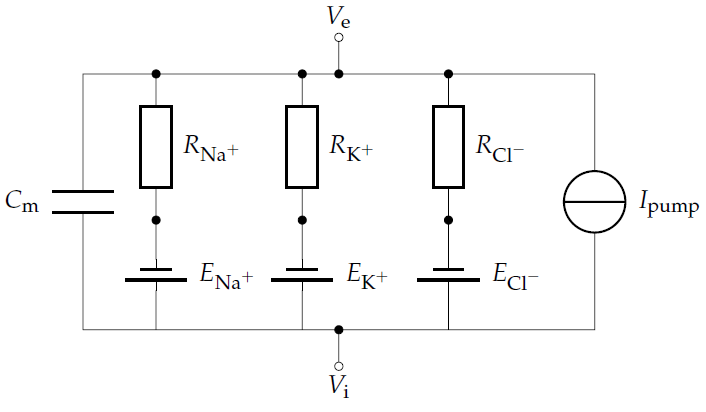


Figure 1: “An equivalent circuit of the cell at resting
potential. Each ion species is represented as a
resistor and a battery. The battery represents the
ions Nernst potential while the resistor defines
how permeable the membrane is for this type of
ion. The membrane is implemented as a capacity
and the ions pumps as a simple current source.”
Hemmert, W.; Encke J. (2017) p.9

## The Leaky Integrate and Fire Model

This first, very basic model is a mere passive description of the neuron's membrane. 
By applying a steady electrical current to the "cell", the membrane potential gets progressively less negative (depolarization) up to the threshhold potential. Upon reaching the treshhold potential, the "cell" fires an action potential and repolarizes instantly.



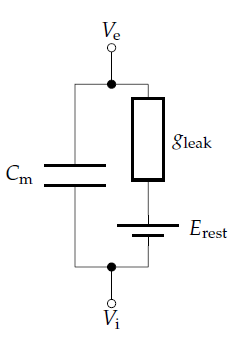

Figure 2: For the Leaky integrate and Fire Model, the original equivalent circuit Fig. 1 can be simplified, by replacing the batteries as well as the resistors with a combined leak
conductance gleak and a battery setting the resting potential Erest
(Figure 3). In this case, the ion pump can be dispensed with, as the
resting potential is maintained by the battery.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


def membrane_voltage(vm, i_stim, cm, g_leak, params):
    r = 1 / g_leak
    tau = cm * r

    for index in range(len(params["time"]) - 1):
        if vm[index] < params["v_thr"]:
            vm[index + 1] = (((-vm[index] + params["v_rest"]) / tau) + (i_stim[index] / cm)) * \
                            params["step_size"] + vm[index]
        elif vm[index] == params["v_spike"]:
            vm[index + 1] = params["v_rest"]
        elif vm[index] > params["v_thr"]:
            vm[index + 1] = params["v_spike"]

    return vm


# Define the params dictionary
params = {
    "v_rest": -70e-3,
    "v_thr": -30e-3,
    "v_spike": 20e-3,
    "step_size": 30e-6,
    "cm": 1e-6,
}

params["time"] = np.arange(0, 0.1, params["step_size"])

# Create an interactive plot using widgets.interact
i_stim_slider = widgets.FloatSlider(
    value=10e-6,
    min=3, 
    max=10, 
    step=2, 
    description='I_stim [uA]',
    continuous_update=False
)

def interactive_plot(i_stim_val):
    vm = np.zeros(len(params["time"]))
    vm[0] = params["v_rest"]

    i_stim = np.zeros(len(params["time"]))
    i_stim[:4999] = i_stim_val/1_000_000 # Stimulation current in uA

    g_leak = 100e-6

    vm = membrane_voltage(vm, i_stim, params["cm"], g_leak, params)

    plt.figure(figsize=(16, 6))
    plt.plot(params["time"], vm)
    plt.axhline(y=-0.03, linestyle="dashed", color="red", label='Threshhold potential (-30mV)')
    plt.xlabel("Time (s)")
    plt.ylabel("Membrane Voltage (V)")
    plt.title("Leaky Integrated Fire Model")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

widgets.interactive(interactive_plot, i_stim_val=i_stim_slider)

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='I_stim [uA]', max=10.0, min…

You can change the stimulation current and observe the effect on the model. Notice that 3 $\mu$ A is not enough to cross the threshhold potential.

## Hodgkin-Huxley-Model

The Hodgkin-Huxley-Model is already quite complex, if you are interested in the details, please consider my written report.

### In very broad terms

This model was published in 1952 by Alan Lloyd Hodgkin und Andrew Fielding Huxley following their experiments on the giant squid axon.
It describes the biophysical properties of a neuron quite accurately by incorporating the properties of Sodium and Potassium channels as well as a leak current by incorporating gating variables that describe the probability of a certain ion channel to be open in relation to the membrane potential.

### Takehome message

This model allows for a pretty precise simulation of a neuron by modeling intricate neurobiological properties.
This model will be revisited further down the line again.



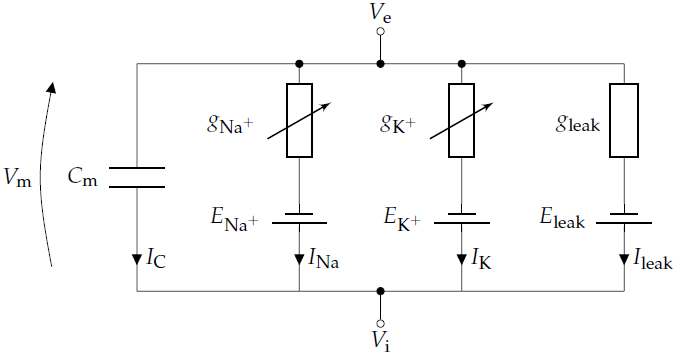

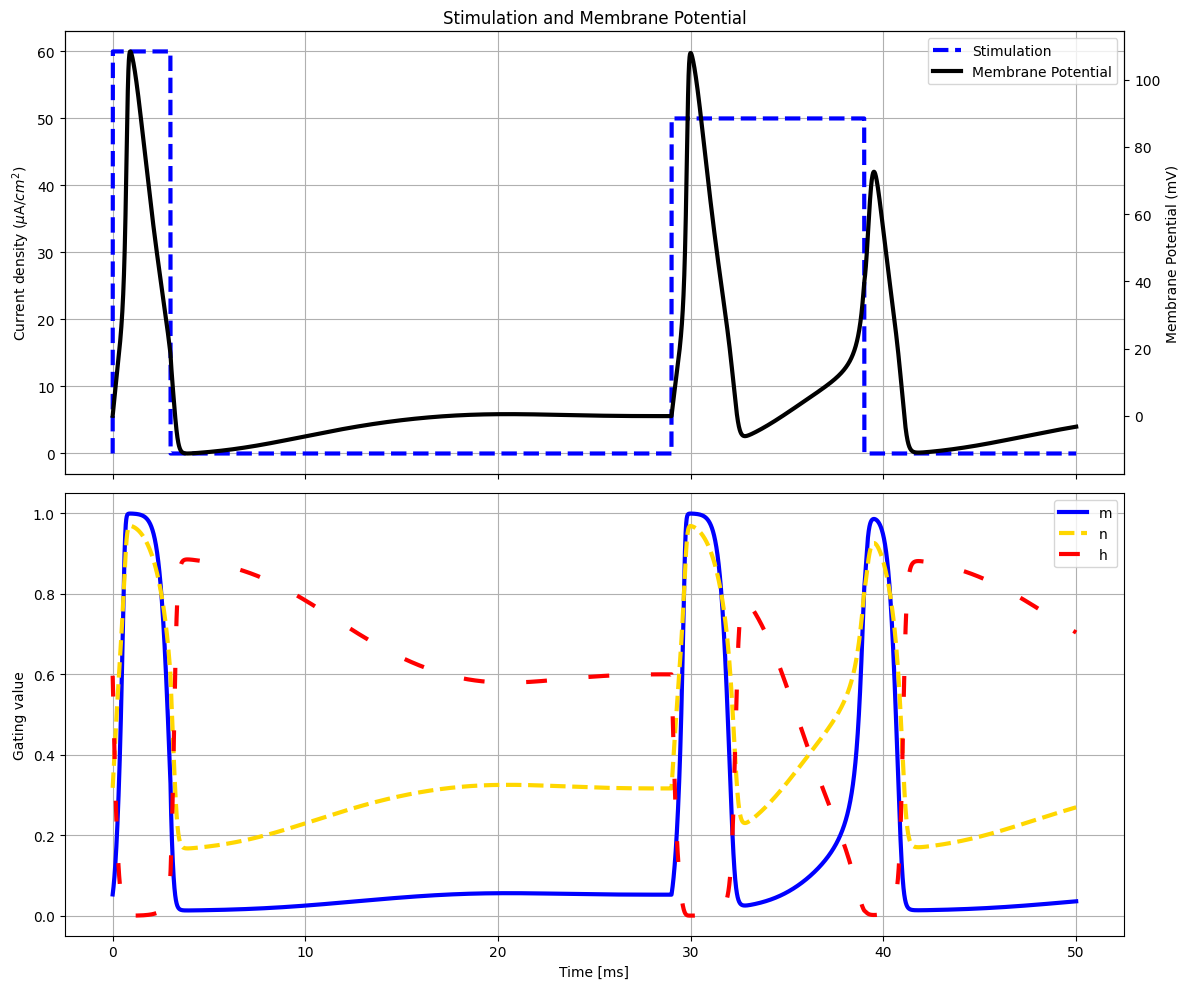

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 50.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))


# Input stimulus
def Id(t):
    if 0.0 < t < 3.0:
        return 60.0
    elif 29.0 < t < 39.0:
        return 50.0
    return 0.0


# Compute derivatives
def compute_derivatives(y, t0):
    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    dy = [
        (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy


# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

# Input stimulus
Idv = np.vectorize(Id)(T)

# Plotting
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# First subplot: Stimulation and Membrane Potential
axes1.plot(T, Idv, linestyle="dashed", color="blue", label='Stimulation', linewidth=3)
axes1.set_ylabel(r'Current density ($\mu$A/$cm^2$)')
axes1.set_title('Stimulation and Membrane Potential')
axes1.grid()

axes1_2 = axes1.twinx()  # Twin axes for membrane potential
axes1_2.plot(T, Vy[:, 0], color='black', label='Membrane Potential', linewidth=3)
axes1_2.set_ylabel('Membrane Potential (mV)')

# Combine the legends from the first subplot
lines1, labels1 = axes1.get_legend_handles_labels()
lines1_2, labels1_2 = axes1_2.get_legend_handles_labels()
axes1_2.legend(lines1 + lines1_2, labels1 + labels1_2, loc='upper right')

# Second subplot: Membrane Potential and Gating Variable "m"
axes2.plot(T, m_inf(Vy[:, 0]), color="blue", linewidth=3, label="m")
axes2.plot(T, n_inf(Vy[:, 0]), color="gold", linewidth=3, label="n", linestyle="dashed")
axes2.plot(T, h_inf(Vy[:, 0]), color="red", linewidth=3, label="h",  linestyle=(0,(5, 10)))
axes2.set_xlabel('Time [ms]')
axes2.set_ylabel('Gating value')
axes2.grid()
axes2.legend()

plt.tight_layout()
plt.show()

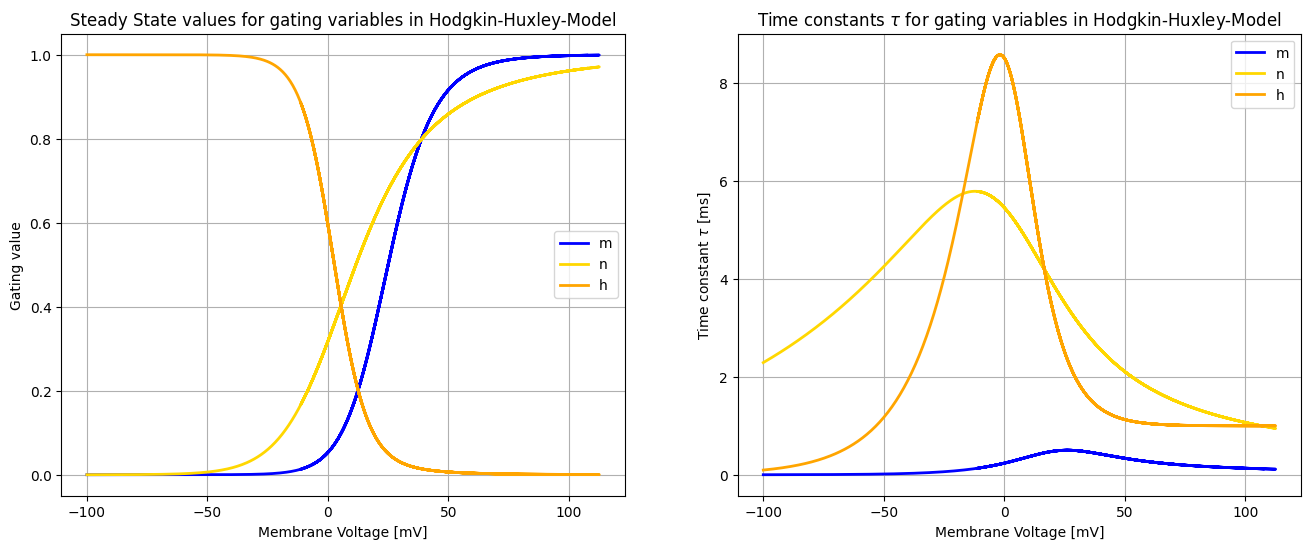

In [63]:
# Initial conditions
Y0 = [-100, n_inf(), m_inf(), h_inf()]

# Solve ODE system (ordinary differential equations)
Vy = odeint(compute_derivatives, Y0, T)

fig, ax = plt.subplots(1,2, figsize=(16, 6))
Vm_values = Vy[:, 0]

ax[0].plot(Vm_values, m_inf(Vm_values), color="blue", linewidth=2, label="m")
ax[0].plot(Vm_values, n_inf(Vy[:, 0]), color="gold", linewidth=2, label="n")
ax[0].plot(Vy[:, 0], h_inf(Vy[:, 0]), color="orange", linewidth=2, label="h")
ax[0].set_xlabel("Membrane Voltage [mV]")
ax[0].set_ylabel("Gating value")
ax[0].set_title("Steady State values for gating variables in Hodgkin-Huxley-Model")
ax[0].legend()
ax[0].grid()


m_time_const = (1/(alpha_m(Vm_values)+beta_m(Vm_values)))
n_time_const = (1/(alpha_n(Vm_values)+beta_n(Vm_values)))
h_time_const = (1/(alpha_h(Vm_values)+beta_h(Vm_values)))

ax[1].plot(Vm_values, m_time_const, color="blue", linewidth=2, label="m")
ax[1].plot(Vm_values, n_time_const, color="gold", linewidth=2, label="n")
ax[1].plot(Vm_values, h_time_const, color="orange", linewidth=2, label="h")

ax[1].set_xlabel("Membrane Voltage [mV]")
ax[1].set_ylabel(r"Time constant $\tau$ [ms]")
ax[1].set_title(r"Time constants $\tau$ for gating variables in Hodgkin-Huxley-Model")
ax[1].legend()
ax[1].grid()


plt.show()


## Passive Cable Neuron Model

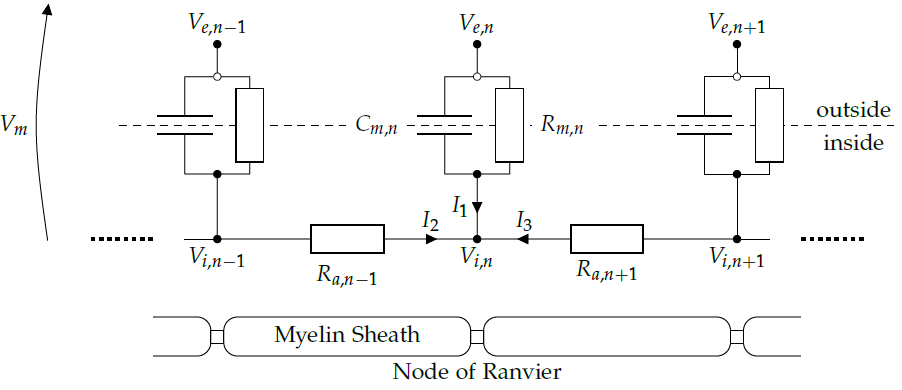

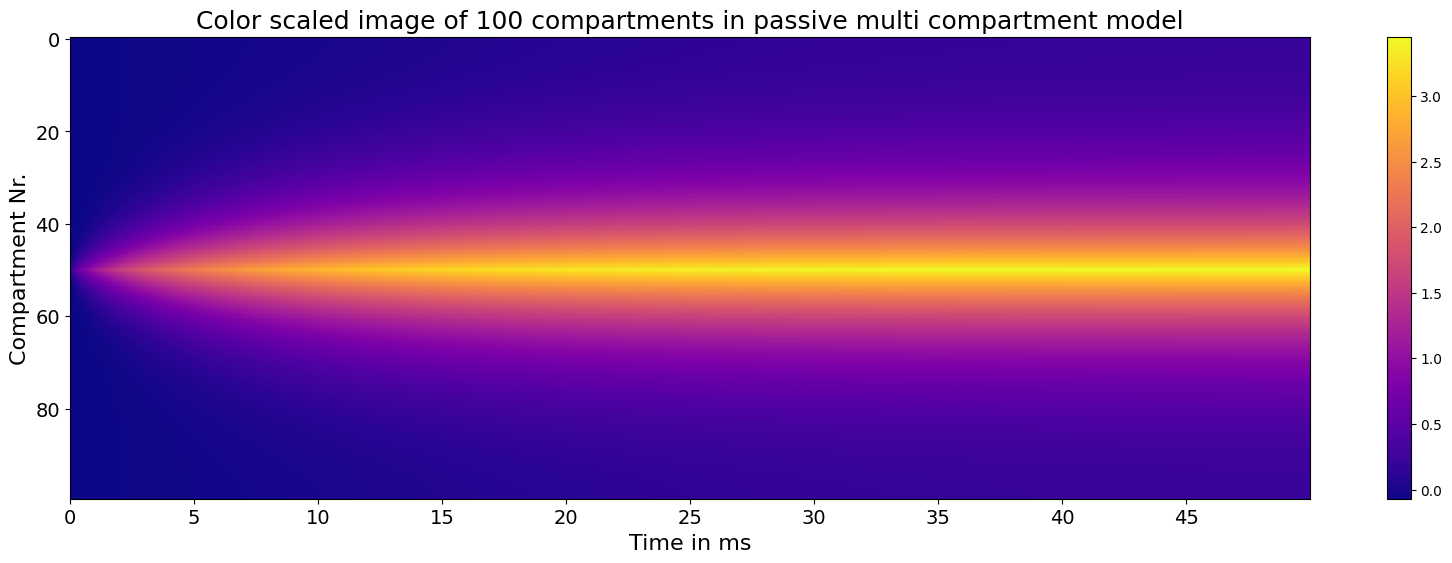

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# time
dt = 0.01
t = np.arange(dt, 50 + dt, dt)

# compartments
n = 100

# membrane
Cm = 1
Rm = 10

# membrane voltage
Vm = np.ones((n, len(t)))*-70e-3

# axon
p = 6e-4
L = 0.1e-4
r = 2e-4
Ra = (p * L) / (np.pi * r ** 2)

c = np.ones(n) * -2
c[0] = -1
c[-1] = -1

C = np.diag(c) + np.diag(np.ones(n - 1), 1) + np.diag(np.ones(n - 1), -1)

A = np.eye(n) - (dt / (Cm * Ra)) * C

Istim = np.zeros((n, len(t)))
Istim[n // 2, :] = 10

for idx in range(len(t) - 1):
    Ihh = Vm[:, idx] / Rm
    b = Vm[:, idx] + (dt / Cm * (-Ihh + Istim[:, idx])).astype(np.float64) # np.float64 prevents RuntimeWarning: overflow encountered in scalar operation
    Vm[:, idx + 1] = np.linalg.solve(A, b)

lambda_val = np.max(Vm[49, :]) * 0.37

# Plots
fig, ax = plt.subplots(figsize=(20, 6))

# Color scaled image of compartments
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_title('Color scaled image of 100 compartments in passive multi compartment model', fontsize=18)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.tick_params(labelsize=14)

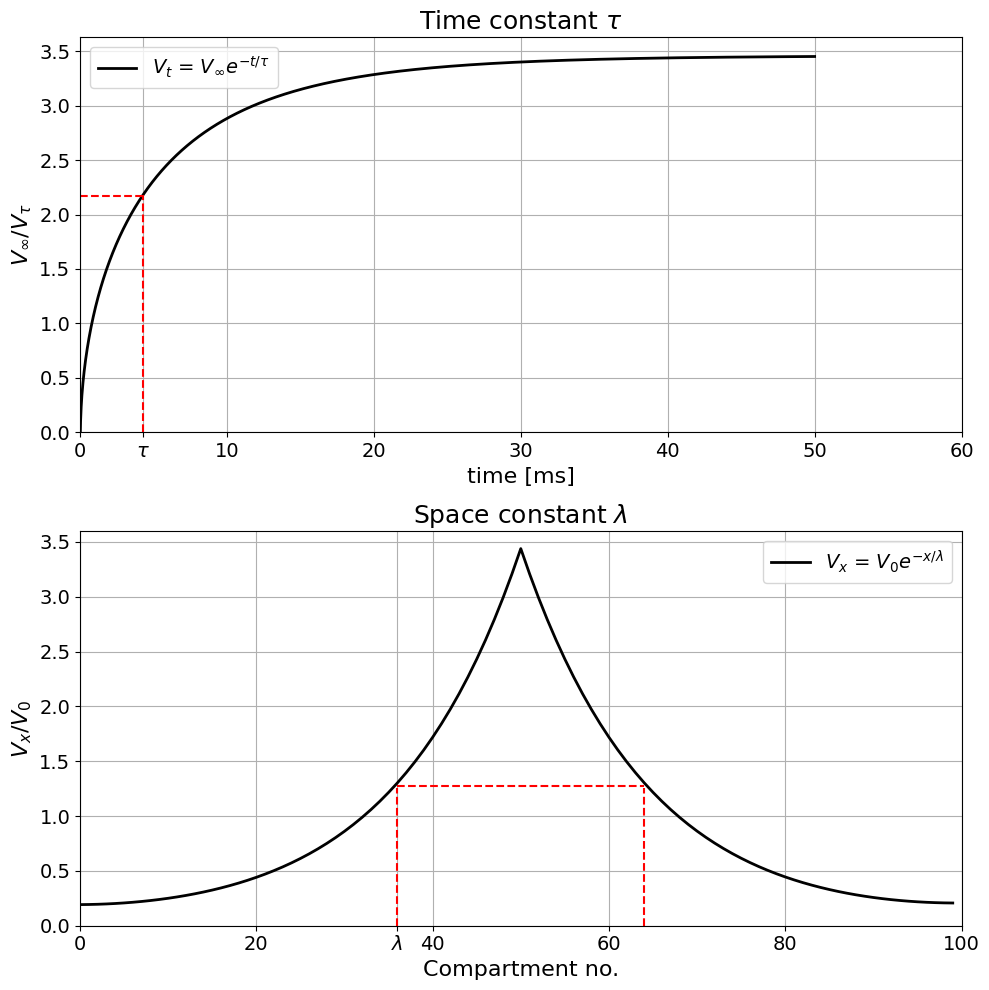

In [65]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize =(10,10))

# Plot 1
# Constant stimulation of compartment 50
ax1.plot(t, Vm[50, :], linewidth=2, color='black', label=r"$V_t$ = $V_\infty$$e^{-t/\tau}$")
ax1.set_xlabel('time [ms]', fontsize=16)
ax1.set_ylabel(r"$V_\infty$/$V_\tau$", fontsize=16)
ax1.set_title(r"Time constant $\tau$", fontsize=18)
ax1.set_xlim(xmin=0)
ax1.set_ylim(ymin=0)
ax1.tick_params(labelsize=14)
ax1.grid(True)

# Calculate the threshold value (63% of the maximum value)
threshold_value = 0.63 * np.max(Vm[50, :])

# Find the index where the membrane potential first exceeds the threshold
exceed_indices = np.where(Vm[50, :] > threshold_value)[0]
first_exceed_index = exceed_indices[0]
threshold_time = t[first_exceed_index]

# Plotting
ax1.axvline(x=t[first_exceed_index],  ymax = 0.6, color='red', linestyle='--')
ax1.axhline(y=threshold_value, xmax = 0.07, color='red', linestyle='--')
ax1.legend(fontsize=14)

# Get existing x-axis tick positions
existing_ticks = ax1.get_xticks()

# Add the threshold time as a special tick
special_ticks = list(existing_ticks) + [threshold_time]

# Set the new tick positions
ax1.set_xticks(special_ticks)

# Set labels for the special tick positions
tick_labels = [str(int(tick)) if tick != threshold_time else r"$\tau$" for tick in special_ticks]
ax1.set_xticklabels(tick_labels)


# Plot 2
# Exponential decay of Vm along the axon at steady state (t = 4000 ms)
ax2.plot(Vm[:, 3999], linewidth=2, color='black', label=r"$V_x$ = $V_0$$e^{-x/\lambda}$")
ax2.set_xlabel('Compartment no.', fontsize=16)
ax2.set_ylabel(r"$V_x$/$V_0$", fontsize=16)
ax2.set_title(r"Space constant $\lambda$", fontsize=18)
ax2.set_xlim(xmin=0)
ax2.set_xlim(xmax=100)
ax2.set_ylim(ymin=0)
ax2.tick_params(labelsize=14)
ax2.grid(True)

# Calculate the threshold value (63% of the maximum value)
threshold_value = 0.37 * np.max(Vm[50, :])

# Find the index where the membrane potential first exceeds the threshold
exceed_indices = np.where(Vm[50, :] > threshold_value)[0]
exceed_compartment = np.where(Vm[:, 3999] > threshold_value)[0]


# Plotting
ax2.axvline(x=exceed_compartment[0],  color='red', ymax = 0.35, linestyle='--')
ax2.axvline(x=exceed_compartment[-1], color='red', ymax = 0.35, linestyle='--')
ax2.axhline(y=threshold_value, color='red', xmin = 0.36, xmax = 0.64, linestyle='--')
ax2.legend(fontsize=14)

# Get existing x-axis tick positions
existing_ticks = ax2.get_xticks()

# Add the threshold time as a special tick
special_ticks = list(existing_ticks) + [exceed_compartment[0]] 

# Set the new tick positions
ax2.set_xticks(special_ticks)

# Set labels for the special tick positions
tick_labels = [str(int(tick)) if tick != exceed_compartment[0] else r"$\lambda$" for tick in special_ticks]
ax2.set_xticklabels(tick_labels)



plt.tight_layout()
plt.show()

## Active Cable Neuron Model

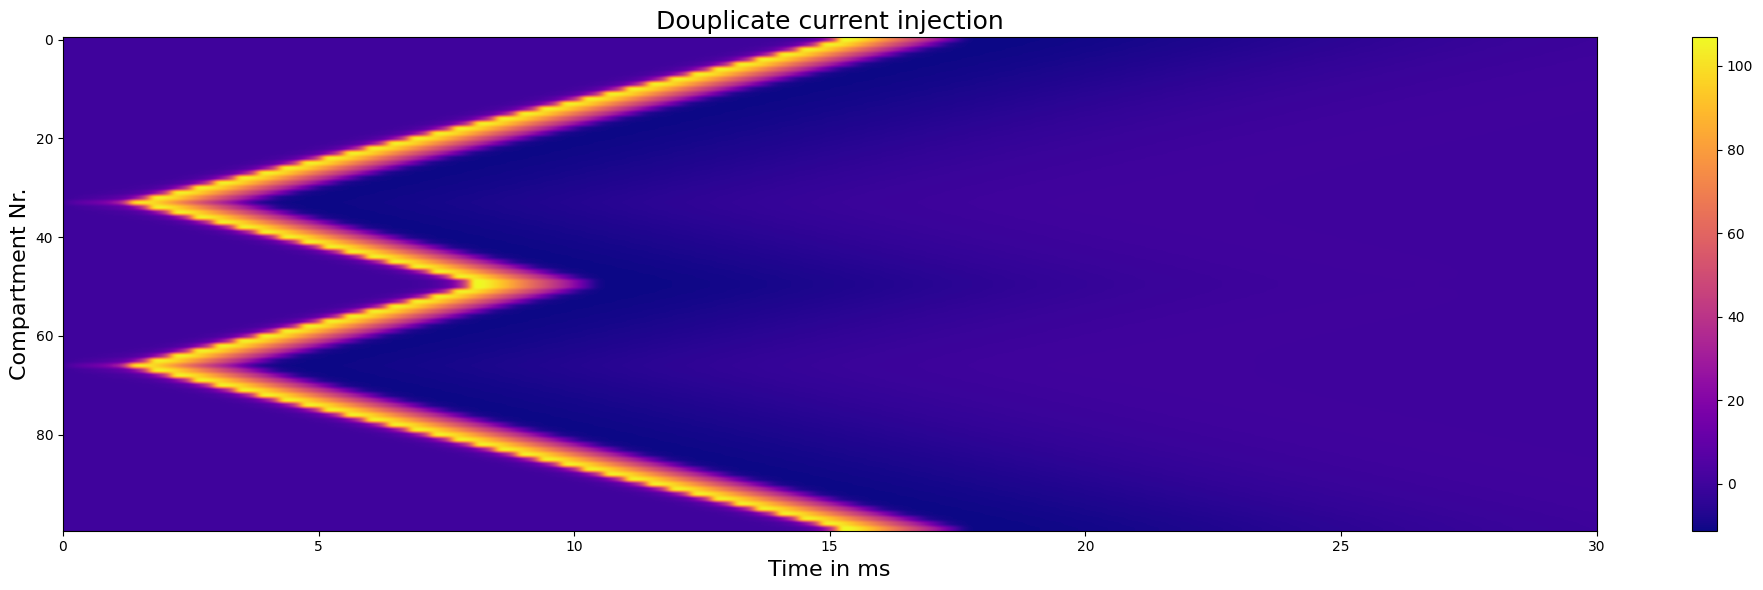

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class HHFormulas:
    def __init__(self):
        self.Vm = None
        self.dt = None
        self.k = None
        self.T = 6.3
        self.gK = 36
        self.eK = -12
        self.gNa = 120
        self.eNa = 115
        self.gL = 0.3
        self.eL = 10.6
        self.alpha_m = None
        self.alpha_n = None
        self.alpha_h = None
        self.beta_m = None
        self.beta_n = None
        self.beta_h = None
        self.tau_m = None
        self.tau_n = None
        self.tau_h = None
        self.p_m = None
        self.p_n = None
        self.p_h = None
        self.m = None
        self.n = None
        self.h = None
        self.iK = None
        self.iNa = None
        self.iL = None

    def calc_all(self):
        self.calculate_gates_and_time_constants()
        self.calculate_mnh()
        self.calculate_currents()

    def calculate_gates_and_time_constants(self):
        self.k_fcn()
        self.alpha_m_fcn()
        self.alpha_n_fcn()
        self.alpha_h_fcn()
        self.beta_m_fcn()
        self.beta_n_fcn()
        self.beta_h_fcn()
        self.tau_m_fcn()
        self.tau_n_fcn()
        self.tau_h_fcn()
        self.p_m_fcn()
        self.p_n_fcn()
        self.p_h_fcn()

    def calculate_mnh(self):
        if self.m is None:
            self.m = self.p_m
            self.n = self.p_n
            self.h = self.p_h
        else:
            self.m_fcn()
            self.n_fcn()
            self.h_fcn()

    def calculate_currents(self):
        self.ik_fcn()
        self.ina_fcn()
        self.il_fcn()

    def tau_m_fcn(self):
        self.tau_m = 1. / (self.alpha_m + self.beta_m)

    def tau_n_fcn(self):
        self.tau_n = 1. / (self.alpha_n + self.beta_n)

    def tau_h_fcn(self):
        self.tau_h = 1. / (self.alpha_h + self.beta_h)

    def p_m_fcn(self):
        self.p_m = self.alpha_m / (self.alpha_m + self.beta_m)

    def p_n_fcn(self):
        self.p_n = self.alpha_n / (self.alpha_n + self.beta_n)

    def p_h_fcn(self):
        self.p_h = self.alpha_h / (self.alpha_h + self.beta_h)

    def alpha_m_fcn(self):
        self.alpha_m = (2.5 - 0.1 * self.Vm) / (np.exp(2.5 - 0.1 * self.Vm) - 1)

    def beta_m_fcn(self):
        self.beta_m = 4 * np.exp(-self.Vm / 18)

    def alpha_n_fcn(self):
        self.alpha_n = (0.1 - 0.01 * self.Vm) / (np.exp(1 - 0.1 * self.Vm) - 1)

    def beta_n_fcn(self):
        self.beta_n = 0.125 * np.exp(-self.Vm / 80)

    def alpha_h_fcn(self):
        self.alpha_h = 0.07 * np.exp(-self.Vm / 20)

    def beta_h_fcn(self):
        self.beta_h = 1 / (np.exp((3 - 0.1 * self.Vm)) + 1)

    def m_fcn(self):
        self.m = self.m + self.dt * self.k * (self.alpha_m * (1 - self.m) - self.beta_m * self.m)

    def n_fcn(self):
        self.n = self.n + self.dt * self.k * (self.alpha_n * (1 - self.n) - self.beta_n * self.n)

    def h_fcn(self):
        self.h = self.h + self.dt * self.k * (self.alpha_h * (1 - self.h) - self.beta_h * self.h)

    def k_fcn(self):
        self.k = 3 ** (0.1 * (self.T - 6.3))

    def ik_fcn(self):
        self.iK = self.gK * self.n ** 4 * (self.Vm - self.eK)

    def ina_fcn(self):
        self.iNa = self.gNa * self.m ** 3 * self.h * (self.Vm - self.eNa)

    def il_fcn(self):
        self.iL = self.gL * (self.Vm - self.eL)


# Create an instance of the HHFormulas class
hh = HHFormulas()

# Define some parameters
hh.dt = 0.01
hh.Vm = 0

# Calculate all
hh.calc_all()

# Define parameters
g_Na = 120e-3  # conductance Sodium [ms/cm2]
g_K = 39e-3    # conductance Potassium [ms/cm2]
g_L = 0.3e-3   # conductance leak [ms/cm2]

v_Na = 115e-3   # voltage Sodium [mV]
v_K = -12e-3    # voltage Potassium [mV]
v_L = 10.6e-3   # voltage leak [mV]
v_Rest = -70e-3  # resting potential [mV]

cm = 1e-6        # membrane capacity [uF/cm2]

p_Axon = 0.1e3   # density axon [kOhm*cm]
r_Axon = 2e-4    # radius axon [cm]
L_comp = 0.1e-4  # length compartment [cm]


# time
dt = 0.01
t = np.arange(dt, 50 + dt, dt)

# compartments
n = 100

# membrane
Cm = 1
Rm = 10

# membrane voltage
Vm = np.zeros((n, len(t)))

# axon
p = 0.1        # conductance for the axon
L = 1e-6       # length for 1 compartment
r = 2e-4       # radius for the axon

# main script formula 2.43
Ra = (p * L) / (np.pi * r ** 2)  # resistance of the axon

# connectivity matrix
c = np.ones((n, 1)) * -2
c[0] = -1
c[-1] = -1

C = np.diag(c[:, 0], 0)
C = C + np.diag(np.ones(n - 1), 1)
C = C + np.diag(np.ones(n - 1), -1)

# part A from exercise_5_slides page 7/9
A = np.eye(n) - (dt / (Cm * Ra)) * C

# stimulus current
Istim = np.zeros((n, len(t)))

# Higher stimulation = more APs
Istim[n // 3, :100] = 30
Istim[n // 3 * 2, :100] = 30

for idx in range(len(t) - 1):
    # calculate all values from class hh_formula
    hh.calc_all()

    # calculate membrane current
    Im = hh.iNa + hh.iK + hh.iL

    # part b from exercise_5_slides page 7/9
    b = Vm[:, idx] + dt / (Cm * Ra) * (-Im + Istim[:, idx])

    # "x"
    Vm[:, idx + 1] = solve(A, b)
    hh.Vm = Vm[:, idx + 1]

# main script figure 2.11 top+botton
fig, ax = plt.subplots(figsize=(20, 6))

# Color scaled image of compartments
im = ax.imshow(Vm, aspect='auto', cmap='plasma')
fig.colorbar(im, ax=ax)


ax.set_title('Douplicate current injection', fontsize=18)
ax.set_xlabel('Time in ms', fontsize=16)
ax.set_ylabel('Compartment Nr.', fontsize=16)
ax.set_xticks(np.arange(0, len(t), len(t) // 10))
ax.set_xticklabels(np.arange(0, 50, 5))
ax.set_xlim(0, 3000)

plt.tight_layout()
plt.show()


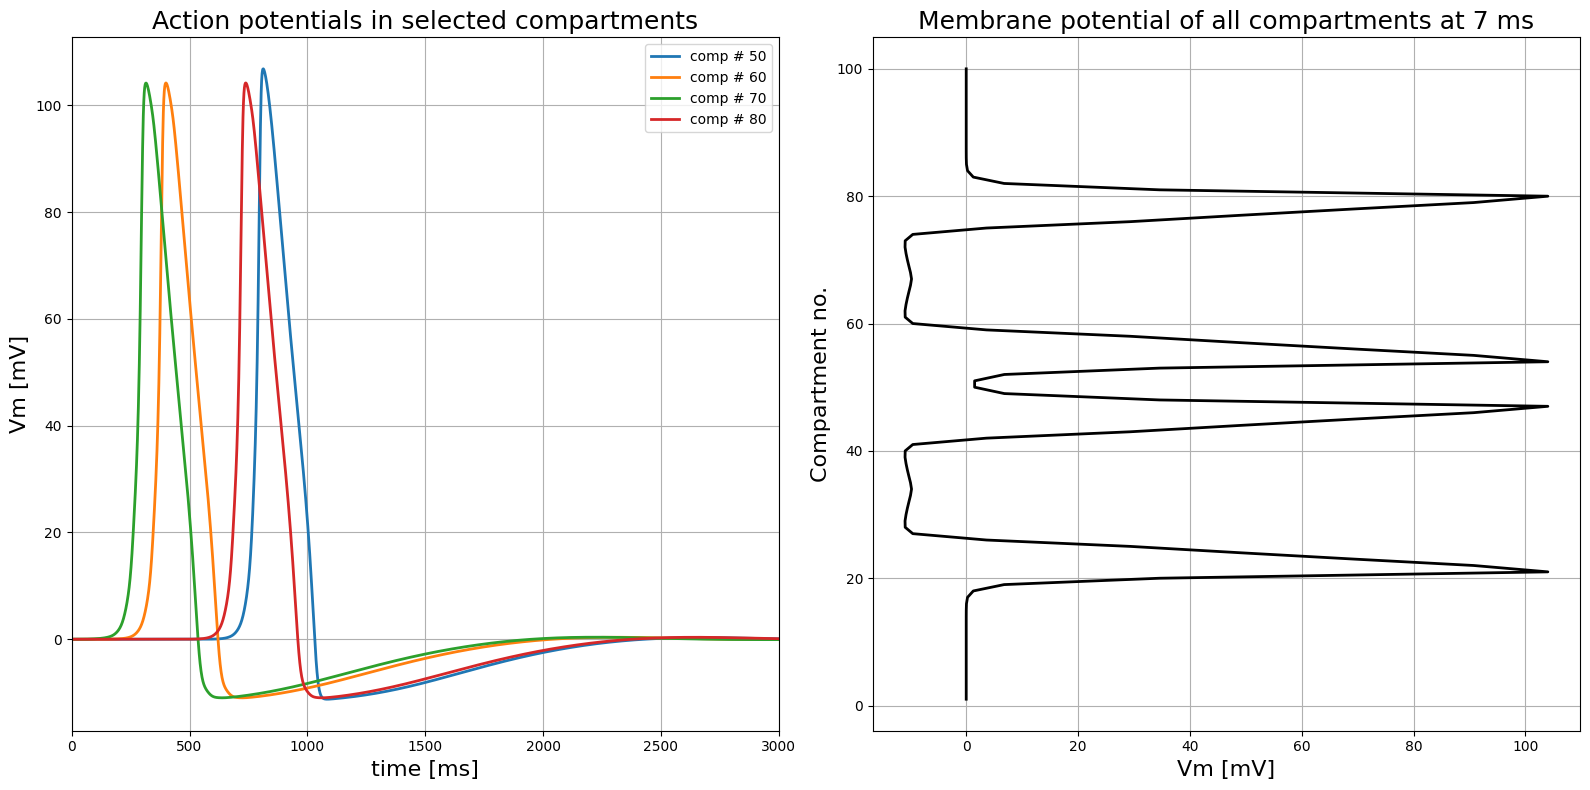

In [67]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
compartments_to_plot = [50, 60, 70, 80]
for comp in compartments_to_plot:
    plt.plot(Vm[comp, :], linewidth=2, label=f'comp # {comp}')
plt.legend()
plt.xlabel('time [ms]', fontsize=16)
plt.ylabel('Vm [mV]', fontsize=16)
plt.title('Action potentials in selected compartments', fontsize=18)
plt.grid(True)
plt.xlim(0, 3000)

plt.subplot(1, 2, 2)
plt.plot(Vm[:, 700], np.arange(1, 101), linewidth=2, color='black')
plt.xlabel('Vm [mV]', fontsize=16)
plt.ylabel('Compartment no.', fontsize=16)
plt.title('Membrane potential of all compartments at 7 ms', fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.show()

## Developing a cochlea implant algorithm

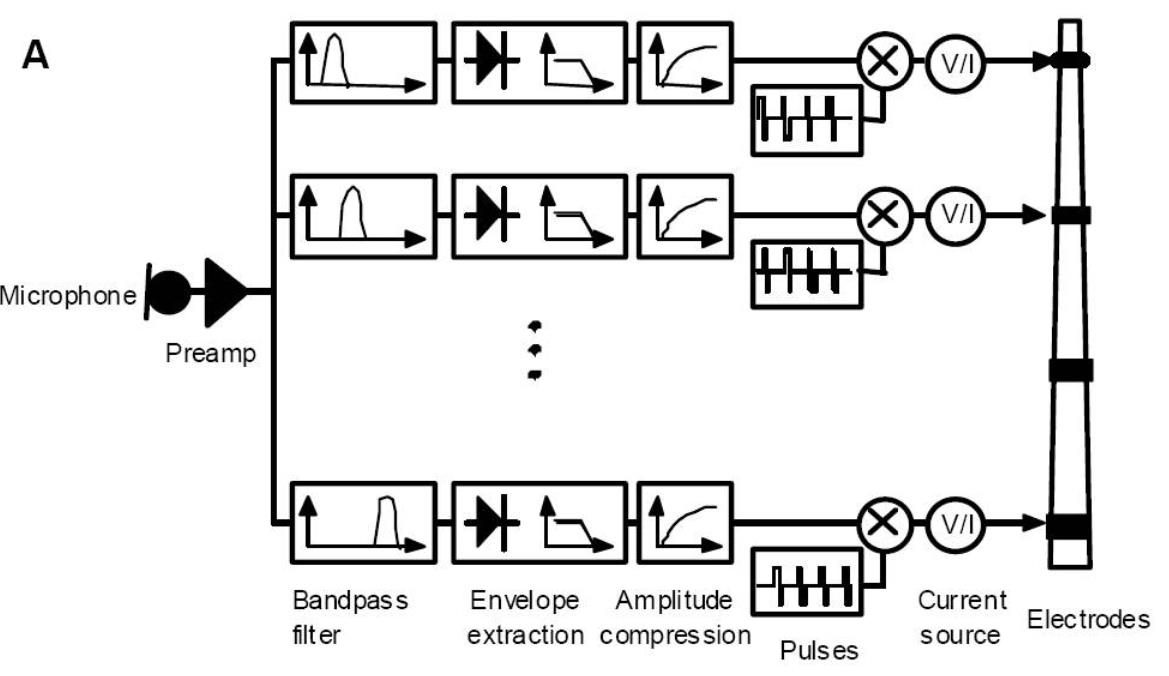

With this theoretical knowledge and the developed neuron models a continuous interleaved sampling
(CIS) algorithm was to be written, which imitates the acoustic process performance of a cochlear
implant. This strategy encodes speech features implicitly by accurately representing the spectro-
temporal structure of the speech signal. The basic idea of this is to divide the incoming sound into a
number of frequency bands. Extracting the temporal envelope in each band and using a compressed
version of the envelope to modulate a fixed rate-train of pulses on each electrode. These pulse trains
are eventually sent to each electrode interleaved in time to prevent unwanted interactions.

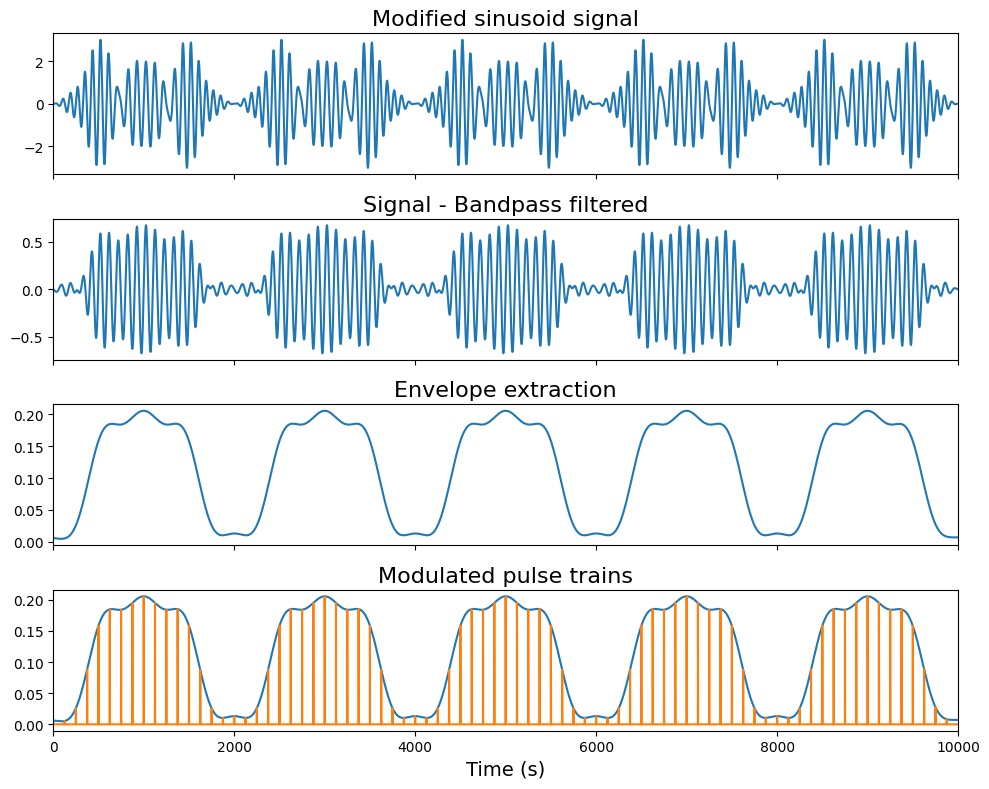

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Build signal
fs = 100000
f = 1000
f2 = 1200
duration = 100e-3  # sec
t = np.arange(0, fs * duration) / fs
signal = np.sin(2 * np.pi * t * f)
signal2 = np.sin(2 * np.pi * t * f2)
mod_sin = (1 - np.cos(2 * np.pi * t * 50))
mod_sin2 = (1 - np.cos(2 * np.pi * t * 100))
signal = signal2 * mod_sin2 + signal * mod_sin

# CIS
# Middle ear
def middle_ear(input, fs):
    order = 2
    fcut = np.array([500, 4000]) / (fs / 2)
    b, a = butter(order, fcut, btype='band')
    out = filtfilt(b, a, input)
    return out

signal = middle_ear(signal, fs)  

# Filterbank
def basilarmembran(signal_in, fs):
    # Only one channel
    signal = signal_in

    # Third octave middle frequencies from 500(-3) to 4k (6) (-1/+1 for border calculation!)
    to_f = 1000 * 2.0 ** np.arange(-4, 8) / 3.0  # Use floating-point numbers

    # Lower/upper border frequencies for the defined to_f
    band_edges = np.sqrt(to_f[:-1] * to_f[1:])

    # Cut the +1/-1
    to_f = to_f[1:-1]

    # Preallocation
    signal_out = np.zeros((len(signal_in), len(to_f)))

    # Filter order
    order = 2

    # Loop over frequency band + filter
    for idx in range(len(to_f)):
        fcut = [band_edges[idx] / (fs / 2), band_edges[idx + 1] / (fs / 2)]  # Divide each element by fs/2
        b, a = butter(order, fcut, btype='band')
        signal_out[:, idx] = filtfilt(b, a, signal)

    return signal_out

filterbank = basilarmembran(signal, fs) 

# Inner ear
def haircell(input, fs):
    cutoff = 200
    order = 4
    compress_power = 1
    
    # Initialize the output envelope
    output = np.zeros_like(input)
    
    for channel in range(input.shape[1]):
        # Half-wave rectification
        rect = np.maximum(input[:, channel], 0)
        
        # Compression
        output[:, channel] = rect ** compress_power
        
        # Lowpass filtering
        fcut = cutoff / (fs / 2)

        # Calculate the required padlen based on the filter order
        padlen = (order * 2) + 1

        # Apply the low-pass filter
        b, a = butter(order, fcut, btype='low')
        output[:, channel] = filtfilt(b, a, output[:, channel], padlen=padlen)
    
    return output


envelope = haircell(filterbank, fs)  

# Kernel
kernel_duration = 200e-6
kernel = np.concatenate((np.ones(int((kernel_duration / 2) * fs)),
                         -np.ones(int((kernel_duration / 2) * fs))))

# Only sizes
n1, n2 = envelope.shape

# PPS
pps = 800

# Period duration in samples
T = round(fs / pps)

# Dirac train (no zero at the first entry!)
pulses = np.zeros(n1)
pulses[range(T - 1, n1, T)] = 1

# Preallocation
final_stim = np.zeros((n1, n2))

for idx in range(n2):
    # Delay for the different electrodes
    phase = 1 / pps * idx / n2
    phase_samples = round(fs * phase)

    # Sampled envelope
    sampled_envelope = pulses * envelope[:, idx]

    # Add the delay
    stim_plus_phase = np.concatenate((np.zeros(phase_samples), np.convolve(sampled_envelope, kernel)))

    # Cut the stim to the right length
    final_stim[:, idx] = stim_plus_phase[:n1]



# Generate modulated pulse trains with a frequency of 800 Hz
def generate_modulated_pulse_trains(fs, duration, pps):
    t = np.arange(0, duration, 1/fs)
    pulse_train = np.zeros(len(t))
    pulse_period = int(fs / pps)
    pulse_train[::pulse_period] = 1
    return pulse_train

# Generate modulated pulse trains for each channel
pps = 800
modulated_pulse_trains = [generate_modulated_pulse_trains(fs, duration, pps) for _ in range(n2)]

# Fit the modulated pulse trains to the envelope
modulated_stim = np.zeros((n1, n2))
for idx in range(n2):
    modulated_stim[:, idx] = modulated_pulse_trains[idx][:n1] * envelope[:, idx]

# Adapt the stimulus from Pascal to μA
final_stim = modulated_stim * 700  # μA

# Plot the results
plt.figure(1, figsize=(10, 8))

# Create subplots with shared x-axis
ax1 = plt.subplot(4, 1, 1)
plt.plot(signal)
plt.title("Modified sinusoid signal", fontsize=16)

ax2 = plt.subplot(4, 1, 2, sharex=ax1)
plt.plot(filterbank[:, 4])
plt.title("Signal - Bandpass filtered", fontsize=16)

ax3 = plt.subplot(4, 1, 3, sharex=ax1)
plt.plot(envelope[:, 4])
plt.title("Envelope extraction", fontsize=16)

ax4 = plt.subplot(4, 1, 4, sharex=ax1)
plt.plot(envelope[:, 4])
plt.plot(modulated_stim[:, 4])
plt.title("Modulated pulse trains", fontsize=16)

# Remove x-axis labels from upper plots
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.xlabel('Time (s)', fontsize=14)  # Label only the bottom subplot
plt.xlim(0, 10_000)

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

## CIS stimulation in a single neuron

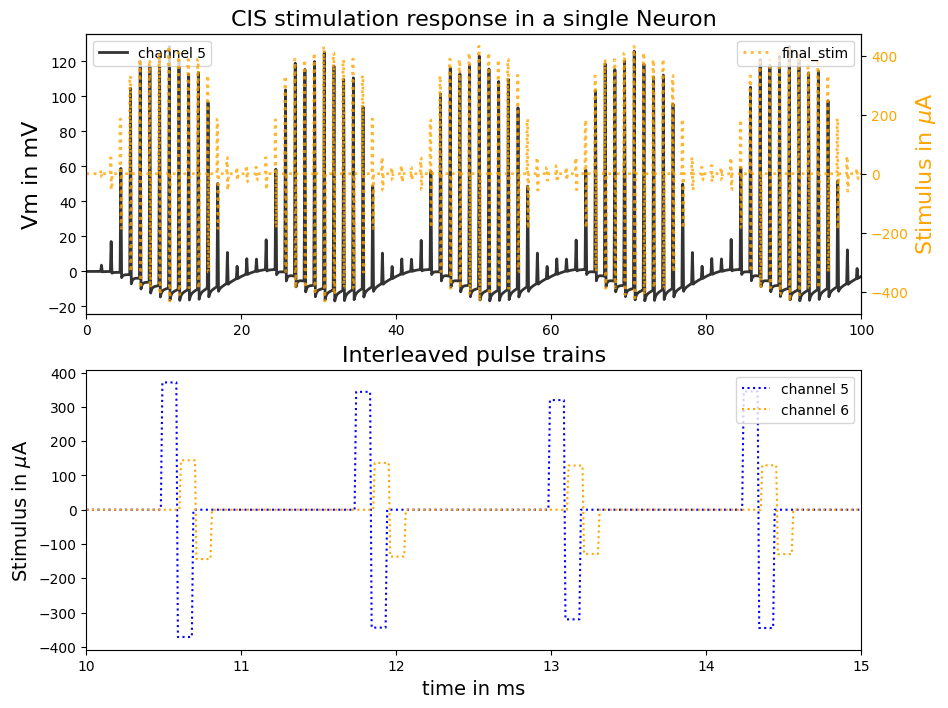

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, convolve
from scipy.integrate import odeint


# Build signal
fs = 100_000 # sampling frequency
f = 1000
f2 = 1200
duration = 100e-3  # 100 ms
t = np.arange(0, fs * duration) / fs
signal = np.sin(2 * np.pi * t * f)
signal2 = np.sin(2 * np.pi * t * f2)
mod_sin = (1 - np.cos(2 * np.pi * t * 50))
mod_sin2 = (1 - np.cos(2 * np.pi * t * 100))
signal = signal2 * mod_sin2 + signal * mod_sin


# CIS
# Middle ear
def middle_ear(input, fs):
    order = 2
    fcut = np.array([500, 4000]) / (fs / 2)
    b, a = butter(order, fcut, btype='band')
    out = filtfilt(b, a, input)
    return out

signal = middle_ear(signal, fs)  

# Filterbank
def basilarmembran(signal_in, fs):
    # Third octave middle frequencies from 500(-3) to 4k (6) (-1/+1 for border calculation!)
    to_f = 1000 * 2.0 ** np.arange(-4, 8) / 3.0  # Use floating-point numbers

    # Lower/upper border frequencies for the defined to_f
    band_edges = np.sqrt(to_f[:-1] * to_f[1:])

    # Cut the +1/-1
    to_f = to_f[1:-1]

    # Preallocation
    signal_out = np.zeros((len(signal_in), len(to_f)))

    # Filter order
    order = 2

    # Loop over frequency band + filter
    for idx in range(len(to_f)):
        fcut = [band_edges[idx] / (fs / 2), band_edges[idx + 1] / (fs / 2)]  # Divide each element by fs/2
        b, a = butter(order, fcut, btype='band')
        signal_out[:, idx] = filtfilt(b, a, signal_in)

    return signal_out

filterbank = basilarmembran(signal, fs) 

# Inner ear
def haircell(input, fs):
    cutoff = 200
    order = 4
    compress_power = 1
    
    # Initialize the output envelope
    output = np.zeros_like(input)
    
    for channel in range(input.shape[1]):
        # Half-wave rectification
        rect = np.maximum(input[:, channel], 0)
        
        # Compression
        output[:, channel] = rect ** compress_power
        
        # Lowpass filtering
        fcut = cutoff / (fs / 2)

        # Calculate the required padlen based on the filter order
        padlen = (order * 2) + 1

        # Apply the low-pass filter
        b, a = butter(order, fcut, btype='low')
        output[:, channel] = filtfilt(b, a, output[:, channel], padlen=padlen)
    
    return output

envelope = haircell(filterbank, fs)  

# Kernel
kernel_duration = 200e-6
kernel = np.concatenate((np.ones(int((kernel_duration / 2) * fs)),
                         -np.ones(int((kernel_duration / 2) * fs))))

# Only sizes
n1, n2 = envelope.shape

# PPS
pps = 800

# Period duration in samples
T = round(fs / pps) # 125

# Dirac train (no zero at the first entry!)
pulses = np.zeros(n1)
pulses[range(T - 1, n1, T)] = 1

# Preallocate final_stim
final_stim = np.zeros((n1, n2))

for idx in range(1, n2 + 1):
    # Delay for the different electrodes
    phase = (1 / pps) * idx / n2
    phase_samples = int(fs * phase)
    
    # Sampled envelope
    sampled_envelope = pulses * envelope[:, idx - 1]  # Adjust for 0-based indexing
    
    # Add the delay
    stim_plus_phase = np.concatenate((np.zeros(phase_samples), convolve(sampled_envelope, kernel)))

    # Cut the stim to the right length
    final_stim[:, idx - 1] = stim_plus_phase[0: n1]

# Generate modulated pulse trains with a frequency of 800 Hz
def generate_modulated_pulse_trains(fs, duration, pps):
    t = np.arange(0, duration, 1/fs)
    pulse_train = np.zeros(len(t))
    pulse_period = int(fs / pps)
    pulse_train[::pulse_period] = 1
    return pulse_train

# Generate modulated pulse trains for each channel
pps = 800
modulated_pulse_trains = [generate_modulated_pulse_trains(fs, duration, pps) for _ in range(n2)]

# Fit the modulated pulse trains to the envelope
modulated_stim = np.zeros((n1, n2))
for idx in range(n2):
    modulated_stim[:, idx] = modulated_pulse_trains[idx][:n1] * envelope[:, idx]


# Adapt the stimulus from Pascal to μA
final_stim = final_stim * 700  # μA


# Hodgkin-Huxley-Model

# Constants
np.random.seed(1000)
tmin = 0.0
tmax = 100.0
gK = 36.0  # Potassium conductivity [ms/cm2]
gNa = 120.0  # Sodium conductivity [ms/cm2]
gL = 0.3  # Leak conductivity [ms/cm2]
Cm = 1.0  # Membrane potential [uF/cm2]
VK = -12.0  # Nernst Potential Potassium [mV]
VNa = 115.0  # Nernst Potential Sodium [mV]
Vl = 10.6  # Leakage potential [mV]
T = np.linspace(tmin, tmax, 10000)


# Ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)


def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)


def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)


def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)


def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


# Steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))


def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))


def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))


idx = 0
channel = 4
stim = final_stim[:, channel]

# Compute derivatives
def compute_derivatives(y, t0):
    global idx
    idx+=1

    Vm, n, m, h = y

    GK = (gK / Cm) * n ** 4.0
    GNa = (gNa / Cm) * m ** 3.0 * h
    GL = gL / Cm

    if t0>= 100:
        t0 = 99.99
    
    dy = [
        (stim[int(t0*100)] / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl)),
        alpha_n(Vm) * (1.0 - n) - beta_n(Vm) * n,
        alpha_m(Vm) * (1.0 - m) - beta_m(Vm) * m,
        alpha_h(Vm) * (1.0 - h) - beta_h(Vm) * h
    ]
    return dy

# Initial conditions
Y0 = [0.0, n_inf(), m_inf(), h_inf()]


Vy = odeint(compute_derivatives, Y0, T)


# Single neuron - plot membrane potential and stimulation current
fig, ax = plt.subplots(2,1, figsize=(10, 8))

ax[0].plot(T, Vy[:, 0]*10, 
           label = "channel 5", 
           color="black", 
           linewidth=2,
           zorder=3,
           alpha=0.8)

ax[0].set_title("CIS stimulation response in a single Neuron", fontsize=16)
ax[0].set_ylabel("Vm in mV", fontsize=16)
ax[0].set_xlim(0, 100)

ax2 = ax[0].twinx()
ax2.plot(T, final_stim[:, channel]*3, 
         color= "orange", 
         label='final_stim', 
         linestyle= ":", 
         linewidth=2,
         alpha=0.8)

ax2.set_ylabel(r'Stimulus in $\mu$A', color="orange", fontsize=16)

# Customize the color of the tick labels on the second x-axis
for tick in ax2.get_yticklabels():
    tick.set_color("orange")

ax[1].plot(T[1000:1500], final_stim[1000:1500, 3]*180, 
           color="blue", 
           label='channel 5', 
           linestyle=":")

ax[1].plot(T[1000:1500], final_stim[1000:1500, 4], 
           color="orange", 
           label='channel 6', 
           linestyle=":")

ax[1].set_title("Interleaved pulse trains", fontsize=16)
ax[1].set_xlim(10,15)
ax[1].set_ylabel(r'Stimulus in $\mu$A', fontsize=14)
ax[1].set_xlabel("time in ms", fontsize=14)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
ax2.legend(loc='upper right')

plt.show()


## Multi Neuron Model - Weighting Matrix

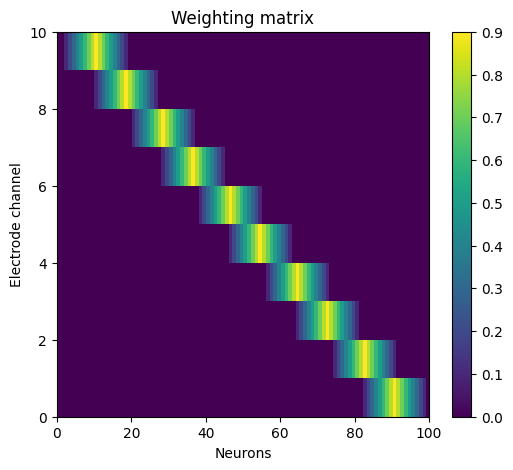

In [76]:
# Multi-neuron version
neurons = 100

# Initialize Vm and t for multiple neurons
Vm = np.zeros((len(final_stim), neurons, n2))
t = np.zeros(len(final_stim))

# Determine the desired size of the window
window_size = n2

# Only a simple triangle for the radiation behavior
window = np.concatenate((np.arange(0, window_size) / window_size, np.arange(window_size - 2, -1, -1) / window_size))


# Weighting matrix for radiation behavior (windows per electrode)
weighting_matrix = np.zeros((n2, neurons))

# Index for the middle of the window
middle_idx = np.round(np.linspace(len(window) / 2, neurons - len(window) / 2, n2)).astype(int)

# Set the triangles in the right place in the matrix
for idx in range(n2):
    idx1 = middle_idx[idx] - len(window) // 2
    idx2 = middle_idx[idx] + len(window) // 2
    weighting_matrix[idx, idx1:idx2 + 1] = window

# Plot the weighting matrix
fig, ax = plt.subplots(figsize=(6, 5))

ax.set_xlabel('Neurons')
ax.set_ylabel('Electrode channel')
ax.set_title('Weighting matrix')

plt.imshow(weighting_matrix, cmap='viridis', aspect='auto', extent=[0, 100, 0, 10])  # Set extent to control axis limits
plt.colorbar()
plt.show()